## This notebook contains a faster and more concise version of code for this project 

In [1]:
import pandas as pd
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from math import isnan

In [2]:
ZERO_RATES = pd.read_csv('yieldcurve.csv').iloc[:,:22].set_index('Maturity') #data, not that the columns are maturity in years

DELTA = 0.5 #length of period
VOL_HL = 0.0173 # vol for the HL model
VOL_BDT = 0.2142 # vol for the BDT model


 # using 21 periods as we only need 20 period trees and need n+1 prices for an n period tree

MATURITIES = ZERO_RATES.columns.astype(float)
PRICES = pd.DataFrame({'PERIOD': MATURITIES * 2,
                      'MATURITY':MATURITIES,
                      'ZERO RATE':ZERO_RATES.values.flatten()/100,
                      'PRICE': 100 * np.exp(-MATURITIES*ZERO_RATES.values.flatten()/100)})

l = PRICES.shape[0]

HL_tree = pd.DataFrame({},columns = range(l),index= range(l) )
BDT_tree = pd.DataFrame({},columns = range(l),index= range(l) )

HL_tree.at[0,0] = PRICES.at[0,'ZERO RATE']
BDT_tree.at[0,0] = PRICES.at[0,'ZERO RATE']



In [3]:
PRICES.style.format({'PERIOD':'{:.0f}','MATURITY':'{:.1f}','ZERO RATE':'{:.2%}','PRICE':'£{:.2f}'})

,PERIOD,MATURITY,ZERO RATE,PRICE
0,1,0.5,0.93%,£99.54
1,2,1.0,0.99%,£99.01
2,3,1.5,1.07%,£98.41
3,4,2.0,1.12%,£97.79
4,5,2.5,1.14%,£97.18
5,6,3.0,1.16%,£96.57
6,7,3.5,1.18%,£95.95
7,8,4.0,1.20%,£95.31
8,9,4.5,1.22%,£94.67
9,10,5.0,1.23%,£94.02


## (a)


In [4]:
def u_or_d(state,period):
    """
    helper function to determine state in the recursive rate function
    """
    if state == 0:
        return 1
    elif state == period:
        return -1
    else:
        return int(-1) ** state
    
def r_HL(theta,state,period):
    """
    this function produces the Ho-Lee model rate given  state and period, 
    assuming previous previous theta has been calibrated
    """
    if isnan(HL_tree.at[state,period]):
        
        ud = u_or_d(state,period)
        state_lag = int(0.5*ud-0.5)
        
        const = HL_tree.at[state + state_lag,period-1]  
        drift = DELTA * theta
        diffusion =np.sqrt(DELTA) * VOL_HL * ud
        
        return const + drift + diffusion 
    else:
        return HL_tree.at[state,period]

def r_BDT(theta,state,period):
    """
    this function produces the Black-Derman-Toy model rate given state and period, 
    assuming previous previous theta has been calibrated
    """
    if isnan(BDT_tree.at[state,period]):
        
        ud = u_or_d(state,period)
        state_lag = int(0.5*ud-0.5)
        
        const = np.log(BDT_tree.at[state + state_lag,period-1])  
        drift = DELTA * theta
        diffusion =np.sqrt(DELTA) * VOL_BDT * ud
        
        return np.exp(const + drift + diffusion) 
    else:
        return BDT_tree.at[state,period]
    
def calibration_function(theta_target,theta_no,HL):
    T = theta_no + 2
    tree = np.zeros((T+1,T+1))
    tree[:,T] = 100
    for p in range(T-1,-1,-1):
        for s in range(p+1):
            if HL:
                rate = r_HL(theta_target,s,p)
            else:
                rate = r_BDT(theta_target,s,p)
            
            tree[s,p] = 0.5*(tree[s,p+1] + tree[s+1,p+1])*np.exp(- rate * DELTA)
            
    return (tree[0,0] - PRICES.at[T-1,'PRICE']) ** 2


In [5]:
calibrated_theta_HL = []
calibrated_theta_BDT = []

for p in range(20):
    
    HL_opt_result = minimize(calibration_function,x0=[0.01],args= (p,True)) 
    BDT_opt_result = minimize(calibration_function,x0=[0.01],args= (p,False)) 

    calibrated_theta_HL.append(HL_opt_result['x'][0])
    calibrated_theta_BDT.append(BDT_opt_result['x'][0])

    for s in range(p + 2):
        HL_tree.at[s,p+1] = r_HL(calibrated_theta_HL[-1],s,p+1)
        BDT_tree.at[s,p+1] = r_BDT(calibrated_theta_BDT[-1],s,p+1)


thetas = pd.DataFrame({'HL':calibrated_theta_HL,'BDT':calibrated_theta_BDT},index = range(20))

In [6]:
(100 * thetas).T.style.format('{:.2f}')

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
HL,0.25,0.38,0.08,0.05,0.11,0.14,0.15,0.16,0.17,0.19,0.20,0.22,0.23,0.25,0.26,0.28,0.29,0.30,0.31,0.32
BDT,22.08,28.80,1.37,-2.37,0.88,2.26,2.18,1.80,1.44,1.32,1.34,1.40,1.45,1.48,1.46,1.38,1.25,1.06,0.82,0.54


In [7]:
HL_tree.style.format('{:.2%}',na_rep ='')

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20
0,0.93%,2.28%,3.69%,4.95%,6.20%,7.48%,8.77%,10.07%,11.38%,12.69%,14.00%,15.33%,16.66%,18.00%,19.35%,20.70%,22.07%,23.43%,24.81%,26.19%,27.57%
1,,-0.17%,1.24%,2.51%,3.76%,5.03%,6.32%,7.62%,8.93%,10.24%,11.56%,12.88%,14.21%,15.55%,16.90%,18.26%,19.62%,20.99%,22.36%,23.74%,25.13%
2,,,-1.20%,0.06%,1.31%,2.59%,3.88%,5.18%,6.48%,7.79%,9.11%,10.43%,11.77%,13.11%,14.46%,15.81%,17.17%,18.54%,19.92%,21.30%,22.68%
3,,,,-2.39%,-1.14%,0.14%,1.43%,2.73%,4.04%,5.35%,6.66%,7.99%,9.32%,10.66%,12.01%,13.36%,14.73%,16.09%,17.47%,18.85%,20.23%
4,,,,,-3.58%,-2.31%,-1.02%,0.28%,1.59%,2.90%,4.22%,5.54%,6.87%,8.21%,9.56%,10.92%,12.28%,13.65%,15.02%,16.40%,17.79%
5,,,,,,-4.75%,-3.46%,-2.16%,-0.86%,0.45%,1.77%,3.09%,4.43%,5.77%,7.12%,8.47%,9.83%,11.20%,12.58%,13.96%,15.34%
6,,,,,,,-5.91%,-4.61%,-3.30%,-1.99%,-0.68%,0.65%,1.98%,3.32%,4.67%,6.02%,7.39%,8.76%,10.13%,11.51%,12.89%
7,,,,,,,,-7.06%,-5.75%,-4.44%,-3.12%,-1.80%,-0.47%,0.87%,2.22%,3.58%,4.94%,6.31%,7.68%,9.06%,10.45%
8,,,,,,,,,-8.20%,-6.89%,-5.57%,-4.24%,-2.91%,-1.57%,-0.22%,1.13%,2.49%,3.86%,5.24%,6.62%,8.00%
9,,,,,,,,,,-9.33%,-8.02%,-6.69%,-5.36%,-4.02%,-2.67%,-1.32%,0.05%,1.42%,2.79%,4.17%,5.55%


In [8]:
BDT_tree.style.format('{:.2%}',na_rep ='')

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20
0,0.93%,1.21%,1.63%,1.90%,2.19%,2.56%,3.01%,3.54%,4.16%,4.87%,5.71%,6.69%,7.84%,9.18%,10.76%,12.62%,14.78%,17.31%,20.24%,23.65%,27.59%
1,,0.89%,1.20%,1.41%,1.62%,1.89%,2.22%,2.62%,3.07%,3.60%,4.22%,4.94%,5.79%,6.78%,7.95%,9.32%,10.92%,12.78%,14.95%,17.47%,20.38%
2,,,0.89%,1.04%,1.19%,1.40%,1.64%,1.93%,2.27%,2.66%,3.12%,3.65%,4.28%,5.01%,5.87%,6.88%,8.06%,9.44%,11.05%,12.90%,15.06%
3,,,,0.77%,0.88%,1.03%,1.21%,1.43%,1.68%,1.96%,2.30%,2.70%,3.16%,3.70%,4.34%,5.08%,5.96%,6.97%,8.16%,9.53%,11.12%
4,,,,,0.65%,0.76%,0.90%,1.05%,1.24%,1.45%,1.70%,1.99%,2.33%,2.73%,3.20%,3.76%,4.40%,5.15%,6.03%,7.04%,8.21%
5,,,,,,0.56%,0.66%,0.78%,0.91%,1.07%,1.26%,1.47%,1.72%,2.02%,2.37%,2.77%,3.25%,3.81%,4.45%,5.20%,6.07%
6,,,,,,,0.49%,0.58%,0.68%,0.79%,0.93%,1.09%,1.27%,1.49%,1.75%,2.05%,2.40%,2.81%,3.29%,3.84%,4.48%
7,,,,,,,,0.43%,0.50%,0.58%,0.68%,0.80%,0.94%,1.10%,1.29%,1.51%,1.77%,2.08%,2.43%,2.84%,3.31%
8,,,,,,,,,0.37%,0.43%,0.51%,0.59%,0.69%,0.81%,0.95%,1.12%,1.31%,1.53%,1.79%,2.10%,2.45%
9,,,,,,,,,,0.32%,0.37%,0.44%,0.51%,0.60%,0.70%,0.83%,0.97%,1.13%,1.33%,1.55%,1.81%


## (b)

In [9]:
PRINCIPAL = 1e5

In [10]:

# coupon of the mortgage 
def coupon(r,N,T):
    return ((N*r*DELTA)/(1-(1+r*DELTA)**-T))

def os_principal(r,N,T): #loan prepayment schedule function
    repay_sh = np.zeros((3,T+1))
    repay_sh[2,0] = N
    cpn = coupon(r,N,T)
    
    for p in range(1,T+1):
        repay_sh[0,p] = r * DELTA * repay_sh[2,p-1]
        repay_sh[1,p] = cpn - repay_sh[0,p]
        repay_sh[2,p] = repay_sh[2,p-1]-repay_sh[1,p]
    return repay_sh

def mortgage_value(r,N,T,HL,return_type): 
    
    wo_prepay = np.zeros((T+1,T+1)) #builds a tree of the mortgage value asssuming no prpayment
    prepay_op = np.zeros((T+1,T+1)) #buids a tree of payoff from prepayment exercise ,considering value of waiting for exercise
    repay_sch = os_principal(r,N,T) #loan prepayment schedule to evaluate os liability
    cpn = coupon(r,N,T)
    
    for p in range(T-1,-1,-1):
        for s in range(p+1): 
            if HL:
                rate = HL_tree.at[s,p]
            else:
                rate = BDT_tree.at[s,p]
                
            dis_f = np.exp(-rate * DELTA)
            
            wo_prepay[s,p] = (cpn + 0.5 * (wo_prepay[s,p+1]+wo_prepay[s+1,p+1])) * dis_f    
            wait_val = 0.5 * (prepay_op[s,p+1]+prepay_op[s+1,p+1]) * dis_f  
            prepay_op[s,p] = max(wait_val, wo_prepay[s,p] - repay_sch[2,p], 0)
    
    if return_type == 'cal':
        return (wo_prepay[0,0] - (prepay_op[0,0] + N)) ** 2
    elif return_type == 'without':
        return wo_prepay
    elif return_type == 'prepay':
        return prepay_op
    else:
        return wo_prepay - prepay_op
                                           
                
            

In [11]:
r_M_HL = minimize(mortgage_value,x0=[0.01],args= (PRINCIPAL,20,True,'cal'),method = 'Nelder-Mead',tol = 1/1e10)['x'][0]
r_M_BDT = minimize(mortgage_value,x0=[0.01],args= (PRINCIPAL,20,False,'cal'),method = 'Nelder-Mead',tol = 1/1e10)['x'][0]


In [12]:
pd.DataFrame({'HL':r_M_HL,'BDT':r_M_BDT}, index = ['Solved rates']).style.format('{:.2%}')

,HL,BDT
Solved rates,3.35%,1.55%


## (c)

In [13]:
SIMS = int(1e5)
np.random.seed(1111)
runs = np.random.randint(2, size=(SIMS, 20))
HL_realisations = [100*HL_tree.at[i,20] for i in np.sum(runs,axis=1)]
BDT_realisations = [100*BDT_tree.at[i,20] for i in np.sum(runs,axis=1)]

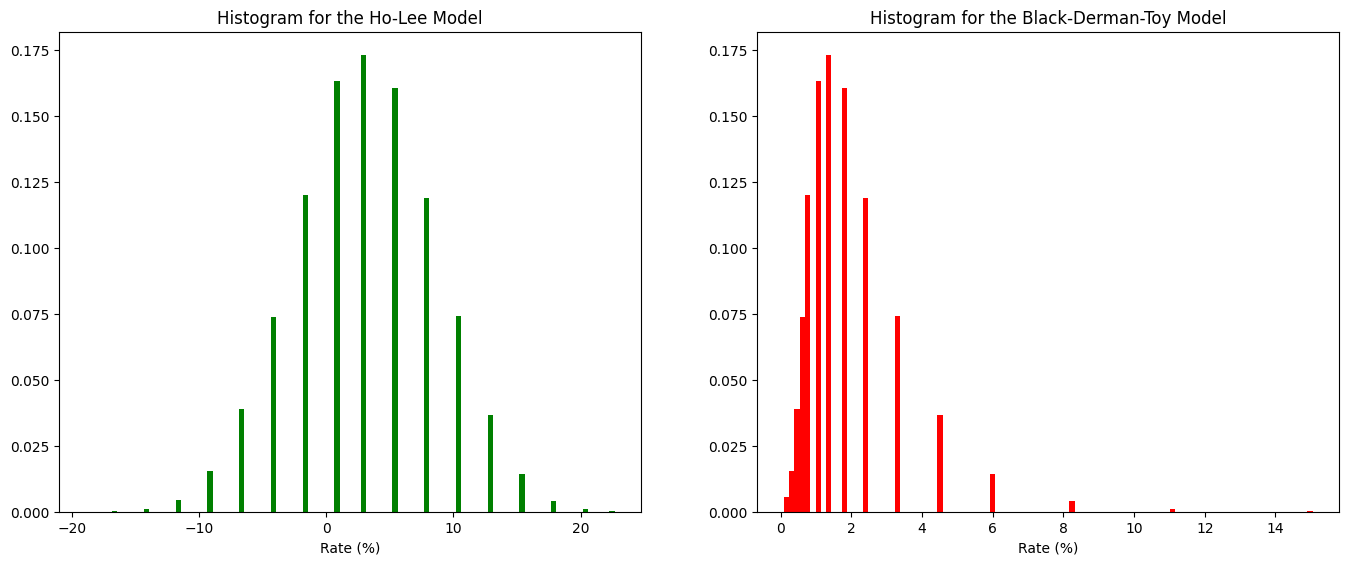

In [14]:
fig,(ax1,ax2) = plt.subplots(nrows=1,ncols=2)

plt.subplots_adjust(left=0, right=2)
plt.subplots_adjust(bottom=0, top=1)

ax1.hist(HL_realisations,weights = np.ones(len(HL_realisations))/len(HL_realisations),bins = 100, color = 'g')
ax1.set_title('Histogram for the Ho-Lee Model')
ax1.set_xlabel('Rate (%)')

ax2.hist(BDT_realisations,weights = np.ones(len(BDT_realisations))/len(BDT_realisations),bins = 100, color = 'r')
ax2.set_title('Histogram for the Black-Derman-Toy Model')
ax2.set_xlabel('Rate (%)')

plt.show()

## (d)

In [15]:
def MC_table(dcf, tree_price = 1e5):
    MC_estimates = np.sum(dcf,axis=1)
    sim_price = np.mean(MC_estimates)
    SE = np.std(MC_estimates)/np.sqrt(SIMS)
    Lower = sim_price-2*SE
    Upper = sim_price+2*SE

    return pd.DataFrame({'MC RESULTS':[SIMS,tree_price,sim_price,SE,Lower,Upper]}, index = ['Simulations', 'Tree Price', 'MC Price','S.E.', 'Lower (95%)', 'Upper (95%)'])

In [16]:
m_under_bdt = mortgage_value(r_M_BDT,PRINCIPAL,20,False,'')
repay_bdt = os_principal(r_M_BDT,PRINCIPAL,20)
repay_bdt[-1,-1] = 0 # setting last value of the repayment schedule to zero as it is a negligible -ve quantity due to
#numerical imprecision

In [17]:
pd.DataFrame(m_under_bdt, index= range(21), columns = range(21)).style.format('{:.0f}')

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20
0,100000,94831,89375,83872,78323,72767,67252,61812,56466,51227,46104,41107,36241,31508,26905,22419,18025,13680,9313,4813,0
1,0,95358,90606,85503,80192,74770,69322,63900,58534,53245,48043,42938,37935,33036,28239,23533,18899,14302,9686,4964,0
2,0,0,90680,85966,81186,76083,70805,65461,60114,54802,49547,44363,39255,34228,29279,24401,19578,14783,9972,5078,0
3,0,0,0,85966,81216,76428,71594,66484,61245,55964,50691,45454,40270,35145,30080,25069,20099,15151,10190,5165,0
4,0,0,0,0,81216,76428,71604,66742,61842,56723,51509,46267,41038,35843,30689,25577,20495,15429,10354,5229,0
5,0,0,0,0,0,76428,71604,66742,61842,56905,51929,46797,41589,36362,31149,25960,20794,15639,10477,5278,0
6,0,0,0,0,0,0,71604,66742,61842,56905,51929,46915,41861,36701,31480,26246,21018,15796,10569,5314,0
7,0,0,0,0,0,0,0,66742,61842,56905,51929,46915,41861,36769,31637,26433,21181,15913,10637,5341,0
8,0,0,0,0,0,0,0,0,61842,56905,51929,46915,41861,36769,31637,26466,21254,15992,10688,5360,0
9,0,0,0,0,0,0,0,0,0,56905,51929,46915,41861,36769,31637,26466,21254,16002,10709,5375,0


In [18]:
pd.DataFrame(repay_bdt, index= ['Interest','Principal','O/S'], columns = range(21)).style.format('{:.0f}')

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20
Interest,0,775,739,703,666,629,592,555,517,479,441,402,364,324,285,245,205,165,124,83,42
Principal,0,4642,4678,4714,4751,4787,4824,4862,4900,4938,4976,5014,5053,5092,5132,5172,5212,5252,5293,5334,5375
O/S,100000,95358,90680,85966,81216,76428,71604,66742,61842,56905,51929,46915,41861,36769,31637,26466,21254,16002,10709,5375,0


In [19]:
trigger = [0]

#range on the for loop excudes the first and last period for obvious reasons
for p in range(1,BDT_tree.shape[1]-1): 
    s = 0
    while m_under_bdt[s,p] < repay_bdt[2,p]:
        s+=1
    trigger.append(BDT_tree.at[s,p])

trigger.append(0)

In [20]:
pd.DataFrame(trigger).T.style.format('{:.2%}')

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20
0,0.00%,0.89%,0.89%,1.04%,0.88%,1.03%,0.90%,1.05%,1.24%,1.07%,1.26%,1.09%,1.27%,1.10%,1.29%,1.12%,1.31%,1.13%,1.33%,1.14%,0.00%


In [21]:
state_count = np.cumsum(runs,axis=1)
rate_path = np.zeros((SIMS,21))
rate_path[:,0] = BDT_tree.at[0,0]
for col in range(state_count.shape[1]):
    for row in range(state_count.shape[0]):
        rate_path[row,col+1] = BDT_tree.at[state_count[row,col],col+1]

cf = coupon(r_M_BDT,PRINCIPAL,20)

dcf = np.zeros((SIMS,21))
for row in range(dcf.shape[0]):
    for col in range(1,dcf.shape[1]):
        disc_fact = np.exp(np.sum(-rate_path[row,0:col])*DELTA)
        dcf[row,col] = cf *disc_fact
        if rate_path[row,col] <= trigger[col]:
            dcf[row,col] += disc_fact * repay_bdt[2,col]
            break
            

In [22]:
MC_table(dcf).style.format('{:.1f}')

,MC RESULTS
Simulations,100000.0
Tree Price,100000.0
MC Price,100055.9
S.E.,3.4
Lower (95%),100049.2
Upper (95%),100062.6


## (e)

In [23]:
# prob of random event
def p(i):
    prob = (1-(1-0.5*min(12*i*DELTA*0.2,6)/100)**DELTA)
    if i%2 == 0:
        prob *= 2
    return prob

# prob of non-optimal prepayment
def q(r):
    return 0.8*np.exp(-20*r)

In [24]:
dcf2 = np.zeros((SIMS,21))

for row in range(dcf2.shape[0]):
    for col in range(1,dcf2.shape[1]):
        p_test = np.random.random() 
        disc_fact = np.exp(np.sum(-rate_path[row,0:col])*DELTA)
        dcf2[row,col] = cf *disc_fact
        
        if p_test < p(col): 
            dcf2[row,col] += disc_fact * repay_bdt[2,col]
            break
            
        elif rate_path[row,col] <= trigger[col]:
            q_test = np.random.random() 
            if q_test<q(rate_path[row,col]):     
                dcf2[row,col] += disc_fact * repay_bdt[2,col]
                break

In [25]:
MC_table(dcf2).style.format('{:.1f}')

,MC RESULTS
Simulations,100000.0
Tree Price,100000.0
MC Price,100206.1
S.E.,3.3
Lower (95%),100199.6
Upper (95%),100212.6


## (f)

In [26]:
r_MBS = r_M_BDT-0.005

In [27]:
repay_mbs = repay_bdt.copy()
repay_mbs[0,1:] = repay_mbs[2,:-1] * DELTA * r_MBS 
pd.DataFrame(repay_mbs, index= ['Interest','Principal','O/S'], columns = range(21)).style.format('{:.0f}')

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20
Interest,0,525,501,476,451,426,401,376,350,325,299,273,246,220,193,166,139,112,84,56,28
Principal,0,4642,4678,4714,4751,4787,4824,4862,4900,4938,4976,5014,5053,5092,5132,5172,5212,5252,5293,5334,5375
O/S,100000,95358,90680,85966,81216,76428,71604,66742,61842,56905,51929,46915,41861,36769,31637,26466,21254,16002,10709,5375,0


In [28]:
# Tree Based MBS pricing

MBS_tree = np.zeros_like(m_under_bdt)
PO_tree = np.zeros_like(m_under_bdt)

for col in range(m_under_bdt.shape[1]-2,-1,-1):
    for row in range(col+1):
        rate = BDT_tree.at[row,col]
        disc_fact = np.exp(-rate*DELTA)
        if rate>trigger[col]:
            MBS_tree[row,col] = disc_fact*(0.5*(MBS_tree[row,col+1]+MBS_tree[row+1,col+1])+np.sum(repay_mbs[0:2,col+1]))
            PO_tree[row,col] = disc_fact*(0.5*(PO_tree[row,col+1]+PO_tree[row+1,col+1])+np.sum(repay_mbs[1,col+1]))
        else:
            MBS_tree[row,col] = np.sum(repay_mbs[2,col])
            PO_tree[row,col] = np.sum(repay_mbs[2,col])
            
IO_tree = MBS_tree-PO_tree       

In [29]:
pd.DataFrame(MBS_tree, index= range(21), columns = range(21)).style.format('{:.0f}')

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20
0,99093,93419,87804,82302,76825,71379,66015,60735,55545,50451,45461,40584,35824,31185,26664,22247,17910,13610,9278,4801,0
1,0,95358,89812,84359,78950,73535,68130,62822,57596,52449,47381,42398,37504,32702,27988,23354,18779,14230,9650,4951,0
2,0,0,90680,85966,80555,75219,69885,64487,59202,54002,48873,43810,38813,33885,29022,24217,19455,14709,9935,5066,0
3,0,0,0,85966,81216,76428,71156,65961,60525,55229,50029,44896,39820,34795,29817,24881,19974,15075,10152,5152,0
4,0,0,0,0,81216,76428,71604,66742,61842,56315,50971,45744,40592,35489,30423,25386,20368,15353,10315,5216,0
5,0,0,0,0,0,76428,71604,66742,61842,56905,51929,46494,41213,36023,30882,25767,20665,15561,10438,5265,0
6,0,0,0,0,0,0,71604,66742,61842,56905,51929,46915,41861,36493,31245,26056,20888,15718,10529,5301,0
7,0,0,0,0,0,0,0,66742,61842,56905,51929,46915,41861,36769,31637,26308,21060,15835,10598,5327,0
8,0,0,0,0,0,0,0,0,61842,56905,51929,46915,41861,36769,31637,26466,21254,15933,10648,5347,0
9,0,0,0,0,0,0,0,0,0,56905,51929,46915,41861,36769,31637,26466,21254,16002,10709,5362,0


In [30]:
pd.DataFrame(PO_tree, index= range(21), columns = range(21)).style.format('{:.0f}')

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20
0,97095,90454,84506,79005,73680,68465,63416,58473,53611,48822,44112,39485,34950,30508,26157,21885,17668,13464,9204,4776,0
1,0,95358,88145,81957,76341,70942,65629,60559,55626,50777,45991,41264,36600,32000,27462,22978,18528,14078,9573,4926,0
2,0,0,90680,85966,79230,73405,67954,62443,57288,52322,47456,42649,37886,33164,28481,23831,19197,14553,9856,5039,0
3,0,0,0,85966,81216,76428,70236,64862,59012,53685,48638,43725,38876,34060,29265,24486,19710,14916,10072,5125,0
4,0,0,0,0,81216,76428,71604,66742,61842,55457,49842,44647,39655,34745,29863,24985,20100,15191,10234,5189,0
5,0,0,0,0,0,76428,71604,66742,61842,56905,51929,45858,40426,35310,30320,25362,20394,15398,10356,5237,0
6,0,0,0,0,0,0,71604,66742,61842,56905,51929,46915,41861,36057,30752,25657,20614,15553,10447,5273,0
7,0,0,0,0,0,0,0,66742,61842,56905,51929,46915,41861,36769,31637,26044,20805,15669,10515,5299,0
8,0,0,0,0,0,0,0,0,61842,56905,51929,46915,41861,36769,31637,26466,21254,15808,10565,5319,0
9,0,0,0,0,0,0,0,0,0,56905,51929,46915,41861,36769,31637,26466,21254,16002,10709,5334,0


In [31]:
pd.DataFrame(IO_tree, index= range(21), columns = range(21)).style.format('{:.0f}')

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20
0,1998,2965,3298,3297,3145,2914,2599,2262,1934,1629,1350,1099,875,678,507,362,242,146,74,25,0
1,0,0,1667,2402,2609,2593,2501,2263,1970,1672,1391,1134,905,702,526,376,251,151,76,26,0
2,0,0,0,0,1325,1814,1931,2044,1915,1680,1416,1161,928,721,540,386,258,156,78,26,0
3,0,0,0,0,0,0,920,1099,1512,1544,1391,1171,944,735,552,395,264,159,80,27,0
4,0,0,0,0,0,0,0,0,0,857,1130,1098,937,744,560,401,268,161,81,27,0
5,0,0,0,0,0,0,0,0,0,0,0,635,788,713,561,405,271,163,82,27,0
6,0,0,0,0,0,0,0,0,0,0,0,0,0,436,493,399,273,165,83,28,0
7,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,264,254,166,83,28,0
8,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,125,83,28,0
9,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,28,0


In [32]:
##  MC based MBS pricing

#optimal prepayment
PO_path = np.zeros((SIMS,21))
IO_path = np.zeros((SIMS,21))
for row in range(PO_path.shape[0]):
    for col in range(1,PO_path.shape[1]):
        disc_fact = np.exp(np.sum(-rate_path[row,0:col])*DELTA)
        PO_path[row,col] = repay_mbs[1,col] *disc_fact
        IO_path[row,col] = repay_mbs[0,col] *disc_fact
        if rate_path[row,col] <= trigger[col]:
            PO_path[row,col] += disc_fact * repay_mbs[2,col]
            break

MBS_path = PO_path + IO_path

#non optimal prepayment
PO_path_2 = np.zeros((SIMS,21))
IO_path_2 = np.zeros((SIMS,21))

for row in range(PO_path_2.shape[0]):
    for col in range(1,PO_path_2.shape[1]):
        p_test = np.random.random() 
        disc_fact = np.exp(np.sum(-rate_path[row,0:col])*DELTA)
        PO_path_2[row,col] = repay_mbs[1,col] *disc_fact
        IO_path_2[row,col] = repay_mbs[0,col] *disc_fact        
        if p_test < p(col): 
            PO_path_2[row,col] += disc_fact * repay_mbs[2,col]
            break            
        elif rate_path[row,col] <= trigger[col]:
            q_test = np.random.random() 
            if q_test<q(rate_path[row,col]):     
                PO_path_2[row,col] += disc_fact * repay_mbs[2,col]
                break
                
MBS_path_2 = PO_path_2 + IO_path_2

In [33]:
# optimal
mbs_sims1 = pd.concat([MC_table(MBS_path,MBS_tree[0,0]),MC_table(PO_path,PO_tree[0,0]),MC_table(IO_path,IO_tree[0,0])],axis=1)
mbs_sims1.columns = ['PASS THROUGH','PO','IO']
mbs_sims1.style.format('{:.1f}')

,PASS THROUGH,PO,IO
Simulations,100000.0,100000.0,100000.0
Tree Price,99093.2,97094.9,1998.3
MC Price,99106.8,97113.6,1993.2
S.E.,5.4,10.8,5.7
Lower (95%),99096.0,97092.1,1981.7
Upper (95%),99117.6,97135.2,2004.6


In [34]:
# non optimal
mbs_sims2 = pd.concat([MC_table(MBS_path_2,MBS_tree[0,0]),MC_table(PO_path_2,PO_tree[0,0]),MC_table(IO_path_2,IO_tree[0,0])],axis=1)
mbs_sims2.columns = ['PASS THROUGH','PO','IO']
mbs_sims2.style.format('{:.1f}')

,PASS THROUGH,PO,IO
Simulations,100000.0,100000.0,100000.0
Tree Price,99093.2,97094.9,1998.3
MC Price,99139.7,96893.8,2245.9
S.E.,5.0,10.1,5.5
Lower (95%),99129.6,96873.6,2234.9
Upper (95%),99149.8,96914.0,2257.0
